Thông tin sinh viên

*   **MSSV**: 16025591.
*   **Họ và tên** : Nguyễn Vũ Khánh Huy.



**Mục tiêu** của notebook này là diễn giải từ tập dữ liệu ban đầu trải qua các bước phân tích dữ liệu để dữ liệu cuối cùng có thể dùng được để train máy học, và thử trên nhiều loại thuật toán khác nhau như Decision Tree, Random Forest...


**Mục lục** của notebook này:
1. Chuẩn bị dữ liệu.
2. Tìm hiểu về nội dung của tập dữ liệu.
3. Tiếp cận phân loại sản phẩm.
4. Tiếp cận phân loại người dùng.
5. Thử phân loại người dùng trên nhiều thuật toán khác nhau.
6. Kết luận.

**1. Chuẩn bị dữ liệu.**

  Import các thư viện cần thiết

In [95]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, nltk, warnings
import matplotlib.cm as cm
import itertools
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from wordcloud import WordCloud, STOPWORDS
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from IPython.display import display, HTML
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot, plot
init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
%matplotlib inline

Import các thư viện riêng cho việc sử dụng google drive trong notebook này, đây là bước quan trọng ở phần đầu không ảnh hưởng nhiều đến các phần sau.

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [89]:
link = 'https://drive.google.com/open?id=1Q0TqCQ5YTsNoCW2a508xEe2To6tD4Db3' # The shareable link
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('data.csv')  
# Dataset is now stored in a Pandas Dataframe

1Q0TqCQ5YTsNoCW2a508xEe2To6tD4Db3


Tập dữ liệu từ file data.csv gồm 541909 dòng và 8 cột.

In [90]:
#__________________
# read the datafile
df_initial = pd.read_csv('data.csv',encoding="ISO-8859-1",
                         dtype={'CustomerID': str,'InvoiceID': str})
print('Dataframe dimensions:', df_initial.shape)
#______
df_initial['InvoiceDate'] = pd.to_datetime(df_initial['InvoiceDate'])
#____________________________________________________________
# gives some infos on columns types and numer of null values
tab_info=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
display(tab_info)
#__________________
# show first lines
display(df_initial[:5])

Dataframe dimensions: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int64,datetime64[ns],float64,object,object
null values (nb),0,0,1454,0,0,0,135080,0
null values (%),0,0,0.268311,0,0,0,24.9267,0


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


Những hàng dữ liệu có cột CustomerID không dữ liệu thì sẽ bị loại bỏ

In [106]:
df_initial.dropna(axis = 0, subset = ['CustomerID'], inplace = True)
print('Số hàng của tập dữ liệu sau khi bỏ các hàng có dữ liệu Null :', df_initial.shape[0])
#____________________________________________________________
# gives some infos on columns types and numer of null values
tab_info=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
display(tab_info)

Số hàng của tập dữ liệu sau khi bỏ các hàng có dữ liệu Null : 401604


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int64,datetime64[ns],float64,object,object
null values (nb),0,0,0,0,0,0,0,0
null values (%),0,0,0,0,0,0,0,0


In [92]:
print('Số hàng bị trùng: {}'.format(df_initial.duplicated().sum()))
df_initial.drop_duplicates(inplace = True)

Số hàng bị trùng: 5225


**2. Tìm Hiểu về nội dung của tập dữ liệu.**

Nội dung của tập dữ liệu: 


*   **InvoiceNo**: Mã đơn đặt hàng (gồm 6 chữ số ). Bắt đầu bằng 'C' nghĩa là đơn hàng 
hủy.

*   **StockCode**: Mã sản phẩm, mỗi sản phẩm có một loại code riêng biệt.

*   **Description**: Tên sản phẩm.
*   **Quantity**: Số lượng sản phẩm trong đơn hàng.


*  **InvoiceDate**: Ngày đặt hàng.


*   **UnitPrice**: Đơn vị tiền tệ dùng mua hàng

*   **CustomerID**: Mã khách hàng.
*   **Country**: Tên quốc gia.






2.1 Quốc gia.

Trong dữ liệu có cột country, cột này gồm 37 quốc gia khác nhau, country của mỗi hàng là quốc gia của mỗi người dùng trong tập dữ liệu.

In [93]:
#2.1 Countries
temp = df_initial[['CustomerID', 'InvoiceNo', 'Country']].groupby(['CustomerID', 'InvoiceNo', 'Country']).count()
temp = temp.reset_index(drop = False)
#orders per country
countries = temp['Country'].value_counts()
print('Số lượng quốc gia trong tập dữ liệu : {}'.format(len(countries)))

Số lượng quốc gia trong tập dữ liệu : 37


Code mô phỏng dữ liệu

In [0]:
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))

Hình bên dưới cho thấy 3 quốc gia sử dụng dịch vụ nhiều nhất là Anh, Pháp, Đức vì có số lượng người dùng đáng kể hơn các quốc gia khác.

In [105]:
data = dict(type='choropleth',
locations = countries.index,
locationmode = 'country names', z = countries,
text = countries.index, colorbar = {'title':'Order nb.'},
colorscale=[[0, 'rgb(224,255,255)'],
            [0.01, 'rgb(166,206,227)'], [0.02, 'rgb(31,120,180)'],
            [0.03, 'rgb(178,223,138)'], [0.05, 'rgb(51,160,44)'],
            [0.10, 'rgb(251,154,153)'], [0.20, 'rgb(255,255,0)'],
            [1, 'rgb(227,26,28)']],    
reversescale = False)
#_______________________
layout = dict(
    title='Số lượng đơn đặt hàng trên từng quốc gia',
    geo = dict(showframe = True, projection={'type':'mercator'})
)
#______________
configure_plotly_browser_state()
choromap = go.Figure(data = [data], layout = layout)
iplot(choromap, validate=False)

2.2 Sơ lược về khách hàng và sản phẩm.

In [0]:
#  2.2 Customers and products
pd.DataFrame([{'products': len(df_initial['StockCode'].value_counts()),    
               'transactions': len(df_initial['InvoiceNo'].value_counts()),
               'customers': len(df_initial['CustomerID'].value_counts()),  
              }], columns = ['products', 'transactions', 'customers'], index = ['quantity'])

,products,transactions,customers
quantity,3684,22190,4372


In [0]:
#*****
temp = df_initial.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket[:10].sort_values('CustomerID')

,CustomerID,InvoiceNo,Number of products
0,12346,541431,1
1,12346,C541433,1
2,12347,537626,31
3,12347,542237,29
4,12347,549222,24
5,12347,556201,18
6,12347,562032,22
7,12347,573511,47
8,12347,581180,11
9,12348,539318,17


2.2.1 Những đơn đặt hàng bị hủy.

In [0]:
#2.2.1 Cancelling orders
nb_products_per_basket['order_canceled'] = nb_products_per_basket['InvoiceNo'].apply(lambda x:int('C' in x))
display(nb_products_per_basket[:5])
#______________________________________________________________________________________________
n1 = nb_products_per_basket['order_canceled'].sum()
n2 = nb_products_per_basket.shape[0]
print('Tỉ lệ đơn bị hủy trên số đơn đặt hàng : {}/{} ({:.2f}%) '.format(n1, n2, n1/n2*100))

,CustomerID,InvoiceNo,Number of products,order_canceled
0,12346,541431,1,0
1,12346,C541433,1,1
2,12347,537626,31,0
3,12347,542237,29,0
4,12347,549222,24,0


Number of orders canceled: 3654/22190 (16.47%) 


Khi nhìn về bảng dữ liệu bên dưới dễ dàng thấy được các đơn **bị hủy** có **ký tự 'C'** trước mỗi mã đơn

In [0]:
display(df_initial.sort_values('CustomerID')[:5])

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346,United Kingdom
286623,562032,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2011-08-02 08:48:00,4.25,12347,Iceland
72260,542237,84991,60 TEATIME FAIRY CAKE CASES,24,2011-01-26 14:30:00,0.55,12347,Iceland
14943,537626,22772,PINK DRAWER KNOB ACRYLIC EDWARDIAN,12,2010-12-07 14:57:00,1.25,12347,Iceland


Một điều đáng chú ý ở hình trên là ngoài hai cột InvoiceNo và Quantity thì các cột còn lại đều giống nhau y hệ ở hàng có InvoiceNo 541431 và C541431. Giả thuyết đặt ra là điều này xảy ra ở tất cả đơn hàng bị hủy.

In [0]:
df_check = df_initial[df_initial['Quantity'] < 0][['CustomerID','Quantity',
                                                   'StockCode','Description','UnitPrice']]
for index, col in  df_check.iterrows():
    if df_initial[(df_initial['CustomerID'] == col[0]) & (df_initial['Quantity'] == -col[1]) 
                & (df_initial['Description'] == col[2])].shape[0] == 0: 
        print(df_check.loc[index])
        print(15*'-'+'>'+' Giả thuyết không phù hợp ! ')
        break

CustomerID        14527
Quantity             -1
StockCode             D
Description    Discount
UnitPrice          27.5
Name: 141, dtype: object
---------------> HYPOTHESIS NOT FULFILLED


In [0]:
df_check = df_initial[(df_initial['Quantity'] < 0) & (df_initial['Description'] != 'Discount')][
                                 ['CustomerID','Quantity','StockCode',
                                  'Description','UnitPrice']]

for index, col in  df_check.iterrows():
    if df_initial[(df_initial['CustomerID'] == col[0]) & (df_initial['Quantity'] == -col[1]) 
                & (df_initial['Description'] == col[2])].shape[0] == 0: 
        print(index, df_check.loc[index])
        print(15*'-'+'>'+' Giả thuyết không phù hợp')
        break

154 CustomerID                               15311
Quantity                                    -1
StockCode                               35004C
Description    SET OF 3 COLOURED  FLYING DUCKS
UnitPrice                                 4.65
Name: 154, dtype: object
---------------> HYPOTHESIS NOT FULFILLED


Vậy là giả thuyết trên không phù hợp, điều đó ảnh hưởng đến việc clean dữ liệu

Hàm bên dưới có hai ý nghĩa :


*   doubtfull_entry: Những đơn đặt hàng bị hủy nhưng không tìm thấy đơn đặt trước đó ( có thể là lỗi dịch vụ ).
*   entry_to_remove: Những đơn đặt hàng bị hủy theo đúng trình tự.



In [0]:
df_cleaned = df_initial.copy(deep = True)
df_cleaned['QuantityCanceled'] = 0

entry_to_remove = [] ; doubtfull_entry = []

for index, col in  df_initial.iterrows():
    if (col['Quantity'] > 0) or col['Description'] == 'Discount': continue        
    df_test = df_initial[(df_initial['CustomerID'] == col['CustomerID']) &
                         (df_initial['StockCode']  == col['StockCode']) & 
                         (df_initial['InvoiceDate'] < col['InvoiceDate']) & 
                         (df_initial['Quantity']   > 0)].copy()
    #_________________________________
    # Cancelation WITHOUT counterpart
    if (df_test.shape[0] == 0): 
        doubtfull_entry.append(index)
    #________________________________
    # Cancelation WITH a counterpart
    elif (df_test.shape[0] == 1): 
        index_order = df_test.index[0]
        df_cleaned.loc[index_order, 'QuantityCanceled'] = -col['Quantity']
        entry_to_remove.append(index)        
    #______________________________________________________________
    # Various counterparts exist in orders: we delete the last one
    elif (df_test.shape[0] > 1): 
        df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
        for ind, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']: continue
            df_cleaned.loc[ind, 'QuantityCanceled'] = -col['Quantity']
            entry_to_remove.append(index) 
            break    

In [0]:
print("Đúng trình tự entry_to_remove: {}".format(len(entry_to_remove)))
print("Không đúng trình tự doubtfull_entry: {}".format(len(doubtfull_entry)))

entry_to_remove: 7521
doubtfull_entry: 1226


Loại cả hai entry_to_remove và doubtfull_entry ra khỏi tập dữ liệu.

Kể cả khi xóa các tập dữ liệu lỗi thì số dòng có Quantity < 0 vẫn còn.

In [0]:
df_cleaned.drop(entry_to_remove, axis = 0, inplace = True)
df_cleaned.drop(doubtfull_entry, axis = 0, inplace = True)
remaining_entries = df_cleaned[(df_cleaned['Quantity'] < 0) & (df_cleaned['StockCode'] != 'D')]
print("Số dòng dữ liệu lỗi còn lại : {}".format(remaining_entries.shape[0]))
remaining_entries[:5]

nb of entries to delete: 48


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
77598,C542742,84535B,FAIRY CAKES NOTEBOOK A6 SIZE,-94,2011-01-31 16:26:00,0.65,15358,United Kingdom,0
90444,C544038,22784,LANTERN CREAM GAZEBO,-4,2011-02-15 11:32:00,4.95,14659,United Kingdom,0
111968,C545852,22464,HANGING METAL HEART LANTERN,-5,2011-03-07 13:49:00,1.65,14048,United Kingdom,0
116064,C546191,47566B,TEA TIME PARTY BUNTING,-35,2011-03-10 10:57:00,0.70,16422,United Kingdom,0
132642,C547675,22263,FELT EGG COSY LADYBIRD,-49,2011-03-24 14:07:00,0.66,17754,United Kingdom,0


Nếu thử với khách hàng có CustomerID là 14048 và với StockCode là 22464 thấy được số hàng bị hủy nhiều hơn số hàng cùng mã **sản phẩm** đã đặt trước đó, khả năng cao là có liên quan đến nhau nên ta sẽ để lại.

In [0]:
df_cleaned[(df_cleaned['CustomerID'] == '14048') & (df_cleaned['StockCode'] == '22464')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
84247,543371,22464,HANGING METAL HEART LANTERN,3,2011-02-07 14:53:00,1.65,14048,United Kingdom,0
84259,543371,22464,HANGING METAL HEART LANTERN,1,2011-02-07 14:53:00,1.65,14048,United Kingdom,0
111968,C545852,22464,HANGING METAL HEART LANTERN,-5,2011-03-07 13:49:00,1.65,14048,United Kingdom,0


2.2.2 Mã sản phẩm

In [0]:
#2.2.2 StockCode
list_special_codes = df_cleaned[df_cleaned['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
list_special_codes

array(['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT'],
      dtype=object)

In [0]:
for code in list_special_codes:
    print("{:<15} -> {:<30}".format(code, df_cleaned[df_cleaned['StockCode'] == code]['Description'].unique()[0]))

POST            -> POSTAGE                       
D               -> Discount                      
C2              -> CARRIAGE                      
M               -> Manual                        
BANK CHARGES    -> Bank Charges                  
PADS            -> PADS TO MATCH ALL CUSHIONS    
DOT             -> DOTCOM POSTAGE                


2.2.3 Giá của giỏ hàng ( Basket price).

Cột **TotalPrice** là tổng giá trị của mỗi giỏ hàng.

In [0]:
#2.2.3 Basket Price
df_cleaned['TotalPrice'] = df_cleaned['UnitPrice'] * (df_cleaned['Quantity'] - df_cleaned['QuantityCanceled'])
df_cleaned.sort_values('CustomerID')[:5]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom,74215,0.0
148288,549222,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2011-04-07 10:43:00,4.25,12347,Iceland,0,17.0
428971,573511,22698,PINK REGENCY TEACUP AND SAUCER,12,2011-10-31 12:25:00,2.95,12347,Iceland,0,35.4
428970,573511,47559B,TEA TIME OVEN GLOVE,10,2011-10-31 12:25:00,1.25,12347,Iceland,0,12.5
428969,573511,47567B,TEA TIME KITCHEN APRON,6,2011-10-31 12:25:00,5.95,12347,Iceland,0,35.7


Mỗi lần đặt hàng sẽ được đặt nhiều sản phẩm, vậy để dễ quan sát ta sẽ gom tổng giá của các sản phẩm và một giỏ hàng.

In [0]:

temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice':'Basket Price'})

df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df_cleaned.drop('InvoiceDate_int', axis = 1, inplace = True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])

basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID')[:6]

,CustomerID,InvoiceNo,Basket Price,InvoiceDate
1,12347,537626,711.79,2010-12-07 14:57:00.000001024
2,12347,542237,475.39,2011-01-26 14:29:59.999999744
3,12347,549222,636.25,2011-04-07 10:42:59.999999232
4,12347,556201,382.52,2011-06-09 13:01:00.000000256
5,12347,562032,584.91,2011-08-02 08:48:00.000000000
6,12347,573511,1294.32,2011-10-31 12:25:00.000001280


Pie chart bên dưới hiển thị cho phân phối giá trị của các đơn đặt hàng

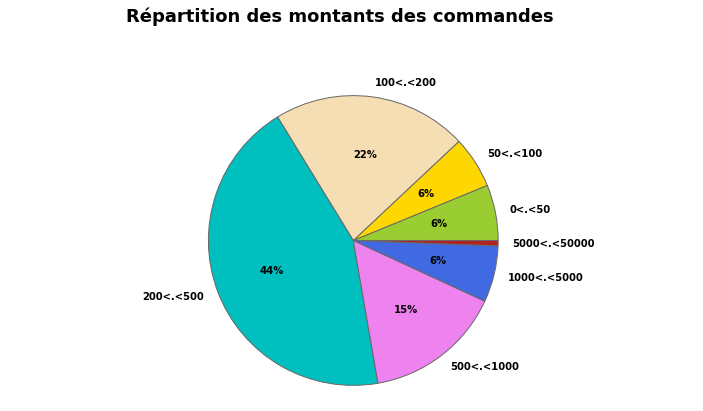

In [0]:

price_range = [0, 50, 100, 200, 500, 1000, 5000, 50000]
count_price = []
for i, price in enumerate(price_range):
    if i == 0: continue
    val = basket_price[(basket_price['Basket Price'] < price) &
                       (basket_price['Basket Price'] > price_range[i-1])]['Basket Price'].count()
    count_price.append(val)
   
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
colors = ['yellowgreen', 'gold', 'wheat', 'c', 'violet', 'royalblue','firebrick']
labels = [ '{}<.<{}'.format(price_range[i-1], s) for i,s in enumerate(price_range) if i != 0]
sizes  = count_price
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]
ax.pie(sizes, explode = explode, labels=labels, colors = colors,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow = False, startangle=0)
ax.axis('equal')
f.text(0.5, 1.01, "Phân phối số lượng giá trị đơn đặt hàng ", ha='center', fontsize = 18);

**3. Tiếp cận phân loại sản phẩm**

3.1 Tìm hiểu về Description của từng sản phẩm.

Hàm bên dưới sẽ trả về 3 giá trị quan trọng là :


*   category_keys: danh sách các từ khóa.

*   keywords_roots: root name của từng loại từ khóa.

*   count_keywords: dictionary cho mỗi loại từ khóa thì sẽ có value là số lần xuất hiện.



Trong quá trình extract ra danh sách từ khóa thì hàm bên dưới sẽ có khả năng rút gọn từ khóa bằng các từ ngăn hơn nhờ keywords_roots.

In [0]:
#3. Insight on product categories
#3.1 Products Description
is_noun = lambda pos: pos[:2] == 'NN'
nltk.download('all')
def keywords_inventory(dataframe, colonne = 'Description'):
    stemmer = nltk.stem.SnowballStemmer("english")
    keywords_roots  = dict()  # collect the words / root
    keywords_select = dict()  # association: root <-> keyword
    category_keys   = []
    count_keywords  = dict()
    icount = 0
    for s in dataframe[colonne]:
        if pd.isnull(s): continue
        lines = s.lower()
        tokenized = nltk.word_tokenize(lines)
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)] 
        
        for t in nouns:
            t = t.lower() ; racine = stemmer.stem(t)
            if racine in keywords_roots:                
                keywords_roots[racine].add(t)
                count_keywords[racine] += 1                
            else:
                keywords_roots[racine] = {t}
                count_keywords[racine] = 1
    
    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:  
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k ; min_length = len(k)            
            category_keys.append(clef)
            keywords_select[s] = clef
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]
                   
    print("Số lượng keywords tìm được '{}': {}".format(colonne,len(category_keys)))
    return category_keys, keywords_roots, keywords_select, count_keywords

In [0]:
df_produits = pd.DataFrame(df_initial['Description'].unique()).rename(columns = {0:'Description'})

In [0]:
keywords, keywords_roots, keywords_select, count_keywords = keywords_inventory(df_produits)

Nb of keywords in variable 'Description': 1483


Sort lại theo số lượng từ giảm dần.

In [0]:
list_products = []
for k,v in count_keywords.items():
    list_products.append([keywords_select[k],v])
list_products.sort(key = lambda x:x[1], reverse = True)

Mô phỏng lại số lượng từ khóa đã sử dụng trong Description.

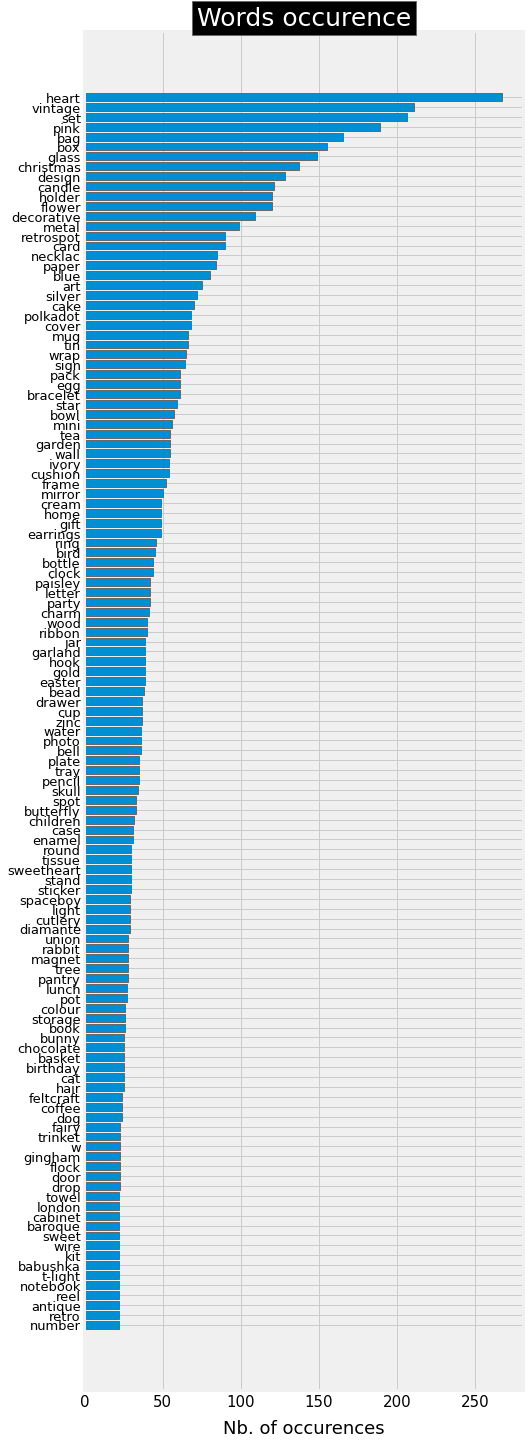

In [0]:
liste = sorted(list_products, key = lambda x:x[1], reverse = True)
#_______________________________
plt.rc('font', weight='normal')
fig, ax = plt.subplots(figsize=(7, 25))
y_axis = [i[1] for i in liste[:125]]
x_axis = [k for k,i in enumerate(liste[:125])]
x_label = [i[0] for i in liste[:125]]
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 13)
plt.yticks(x_axis, x_label)
plt.xlabel("Nb. of occurences", fontsize = 18, labelpad = 10)
ax.barh(x_axis, y_axis, align = 'center')
ax = plt.gca()
ax.invert_yaxis()
#_______________________________________________________________________________________
plt.title("Sô lượng xuất hiện từng từ",bbox={'facecolor':'k', 'pad':5}, color='w',fontsize = 25)
plt.show()

Từ dữ kiện trên ta có được ta kết luận được là có hơn 1400 từ loại được sử dụng trong phần Description của mỗi sản phẩm, có từ được sử dụng trên hơn 200 sản phẩm.

3.2 Định nghĩa loại sản phẩm.

Để tăng sự gọn nhẹ thì ta loại luôn các từ khóa liên quan đến **màu** ( thông tin về màu không khiến cho việc phân loại người dùng dễ dàng hơn ) và ta cũng chỉ chọn các loại từ khóa có số lần xuất hiện nhiều hơn 13 ( 13 là một con số random mang tính tượng trưng ) mục đích chính là giảm bớt các từ loại nhỏ chỉ giữ lại những từ có khả năng để phân vùng sản phẩm.

In [0]:
#3.2 Defining product categories
list_products = []
for k,v in count_keywords.items():
    word = keywords_select[k]
    if word in ['pink', 'blue', 'tag', 'green', 'orange']: continue
    if len(word) < 3 or v < 13: continue
    if ('+' in word) or ('/' in word): continue
    list_products.append([word, v])
#______________________________________________________    
list_products.sort(key = lambda x:x[1], reverse = True)
print('Lượng những từ có khả năng để phân vùng sản phẩm: ', len(list_products))

mots conservés: 193


**3.2.1 Mã hóa dữ liệu**

Tạo ra một ma trận X với trục y là Description trong các sản phẩm,  trục x là các từ loại trong list_products, X(x,y)  = 1 khi và chỉ khi có từ loại y xuất hiện trong x. 

In [0]:
#3.2.1 Data encoding
liste_produits = df_cleaned['Description'].unique()
X = pd.DataFrame()
for key, occurence in list_products:
    X.loc[:, key] = list(map(lambda x:int(key.upper() in x), liste_produits))

Thêm phạm vi về giá cho ma trận X, thêm 6 cột phạm vi để quan sát giá của từng loại sản phẩm đi kèm với nhãn sản phẩm.

In [0]:
threshold = [0, 1, 2, 3, 5, 10]
label_col = []
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])
    label_col.append(col)
    X.loc[:, col] = 0

for i, prod in enumerate(liste_produits):
    prix = df_cleaned[ df_cleaned['Description'] == prod]['UnitPrice'].mean()
    j = 0
    while prix > threshold[j]:
        j+=1
        if j == len(threshold): break
    X.loc[i, label_col[j-1]] = 1

In [0]:
print("{:<8} {:<20} \n".format('Phạm vi', 'Số lượng sản phẩm') + 20*'-')
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])    
    print("{:<10}  {:<20}".format(col, X.loc[:, col].sum()))

gamme    nb. produits         
--------------------
0<.<1       964                 
1<.<2       1009                
2<.<3       673                 
3<.<5       606                 
5<.<10      470                 
.>10        156                 


3.2.2 Bước đầu tiếp cận cụm sản phẩm.

Dùng thuật KMeans để tìm số lượng cụm phù hợp nhất để phân loại sản phẩm.

silhouette_score càng lớn thì chứng minh số điểm thuộc mỗi cụm riêng biệt càng hợp lý ( hay nói cách khác là tốt ).

In [0]:
# 3.2.2 Creating clusters of products
matrix = X.values
for n_clusters in range(3,10):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 3 The average silhouette_score is : 0.10071681758064248
For n_clusters = 4 The average silhouette_score is : 0.12609893747265383
For n_clusters = 5 The average silhouette_score is : 0.1452148389646187
For n_clusters = 6 The average silhouette_score is : 0.14389114353988738
For n_clusters = 7 The average silhouette_score is : 0.14825237367665517
For n_clusters = 8 The average silhouette_score is : 0.14829534761315424
For n_clusters = 9 The average silhouette_score is : 0.1333916640709574


Sau khi đã chạy thử tất cả các cụm bằng Kmeans ta thấy được số điểm giữa các lần chạy không khác nhau quá đáng kể, tuy vậy với n_cluster > 5 số điểm có xu hướng giảm nên ta quyết định n_cluster = 5 là số lượng cụm được chọn.

Kiểm tra lần nữa với n_cluster = 5 thì thấy được silhouette_score không khác biệt( tốt ).

In [0]:
n_clusters = 5
silhouette_avg = -1
while silhouette_avg < 0.145:
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    
    #km = kmodes.KModes(n_clusters = n_clusters, init='Huang', n_init=2, verbose=0)
    #clusters = km.fit_predict(matrix)
    #silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 5 The average silhouette_score is : 0.1466257603527048


3.2.3 Phân tách nội dung từng cụm sản phẩm.

Sô lượng sản phẩm trong mỗi cụm

In [0]:
#3.2.3 Characterizing the content of clusters
pd.Series(clusters).value_counts()

1    1009
2     964
3     762
0     673
4     470
dtype: int64

In [0]:
def graph_component_silhouette(n_clusters, lim_x, mat_size, sample_silhouette_values, clusters):
    plt.rcParams["patch.force_edgecolor"] = True
    plt.style.use('fivethirtyeight')
    mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
    #____________________________
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(8, 8)
    ax1.set_xlim([lim_x[0], lim_x[1]])
    ax1.set_ylim([0, mat_size + (n_clusters + 1) * 10])
    y_lower = 10
    for i in range(n_clusters):
        #___________________________________________________________________________________
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / n_clusters)        
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                           facecolor=color, edgecolor=color, alpha=0.8)
        #____________________________________________________________________
        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.03, y_lower + 0.5 * size_cluster_i, str(i), color = 'red', fontweight = 'bold',
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round, pad=0.3'))
        #______________________________________
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10 

Bên dưới là mô phỏng điểm silhouette trên 5 cụm sản phẩm bắt đầu tù 0 đến 4.

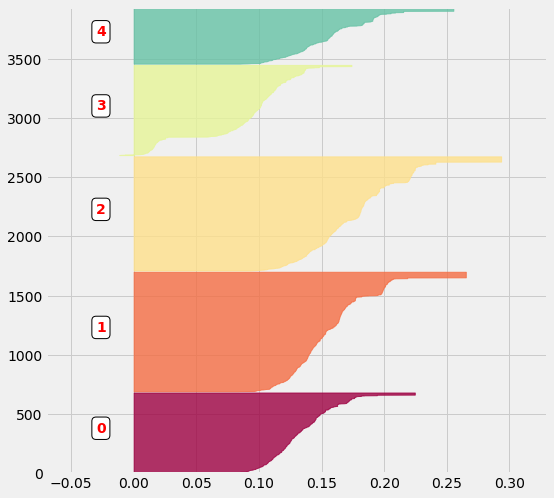

In [0]:
#____________________________________
# define individual silouhette scores
sample_silhouette_values = silhouette_samples(matrix, clusters)
#__________________
# and do the graph
graph_component_silhouette(n_clusters, [-0.07, 0.33], len(X), sample_silhouette_values, clusters)

In [0]:
liste = pd.DataFrame(liste_produits)
liste_words = [word for (word, occurence) in list_products]

occurence = [dict() for _ in range(n_clusters)]

for i in range(n_clusters):
    liste_cluster = liste.loc[clusters == i]
    for word in liste_words:
        if word in ['art', 'set', 'heart', 'pink', 'blue', 'tag']: continue
        occurence[i][word] = sum(liste_cluster.loc[:, 0].str.contains(word.upper()))

Các hàm bên dưới phục vụ cho việc mô phỏng **wordCloud**

Mục đích của việc mô phỏng **wordCloud** cho ta thấy các từ khóa được sử dụng nhiều nhất trong mỗi **cụm** sản phẩm.

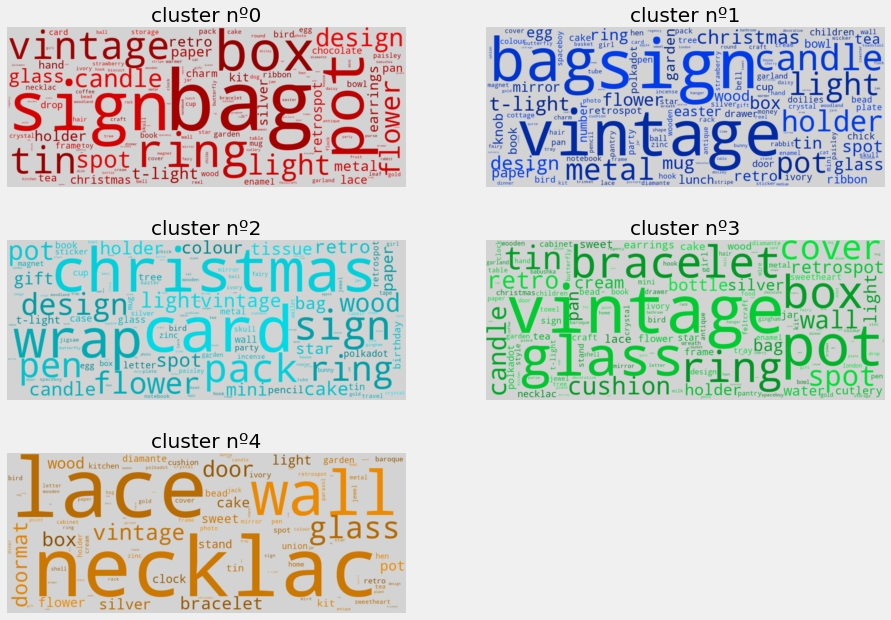

In [0]:
#________________________________________________________________________
def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)
#________________________________________________________________________
def make_wordcloud(liste, increment):
    ax1 = fig.add_subplot(4,2,increment)
    words = dict()
    trunc_occurences = liste[0:150]
    for s in trunc_occurences:
        words[s[0]] = s[1]
    #________________________________________________________
    wordcloud = WordCloud(width=1000,height=400, background_color='lightgrey', 
                          max_words=1628,relative_scaling=1,
                          color_func = random_color_func,
                          normalize_plurals=False)
    wordcloud.generate_from_frequencies(words)
    ax1.imshow(wordcloud, interpolation="bilinear")
    ax1.axis('off')
    plt.title('cluster nº{}'.format(increment-1))
#________________________________________________________________________
fig = plt.figure(1, figsize=(14,14))
color = [0, 160, 130, 95, 280, 40, 330, 110, 25]
for i in range(n_clusters):
    list_cluster_occurences = occurence[i]

    tone = color[i] # define the color of the words
    liste = []
    for key, value in list_cluster_occurences.items():
        liste.append([key, value])
    liste.sort(key = lambda x:x[1], reverse = True)
    make_wordcloud(liste, i+1)        

PCA được sử dụng để xác định một lần nữa về quyết định sử dụng cụm sản phẩm như bên trên là đã đủ **tốt** hay **chưa**, tốt ở đây nghĩa là sự khác biệt trong phân loại giữa các loại sản phẩm là lớn, hay nói cách khác là mỗi cụm **là hoàn toàn độc nhất.**

In [0]:
# Principal Component Analysis
pca = PCA()
pca.fit(matrix)
pca_samples = pca.transform(matrix)

Dễ dàng thấy được để giải thích được hết 90% dữ liệu thì ta cần đến hơn 100 components.

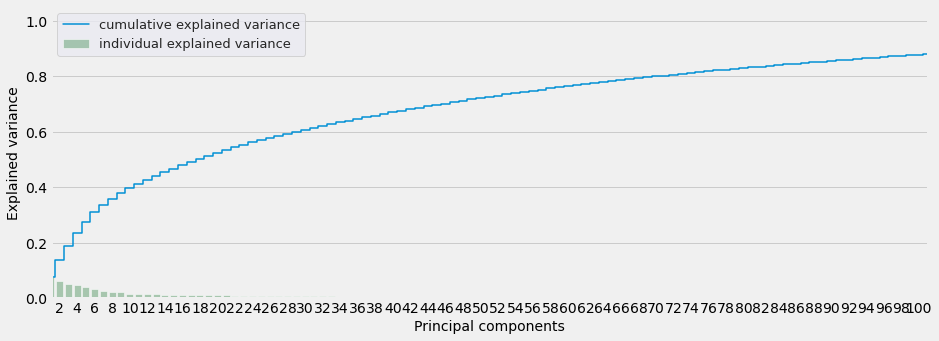

In [0]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='cumulative explained variance')
sns.barplot(np.arange(1,matrix.shape[1]+1), pca.explained_variance_ratio_, alpha=0.5, color = 'g',
            label='individual explained variance')
plt.xlim(0, 100)

ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='upper left', fontsize = 13);

**Mục đích là mô phỏng dữ liệu** nên nếu ta dùng n_components = 50 thì vẫn diễn tả được hơn  75% dữ liệu nên ta sẽ chọn n_components = 50.

In [0]:
pca = PCA(n_components=50)
matrix_9D = pca.fit_transform(matrix)
mat = pd.DataFrame(matrix_9D)
mat['cluster'] = pd.Series(clusters)

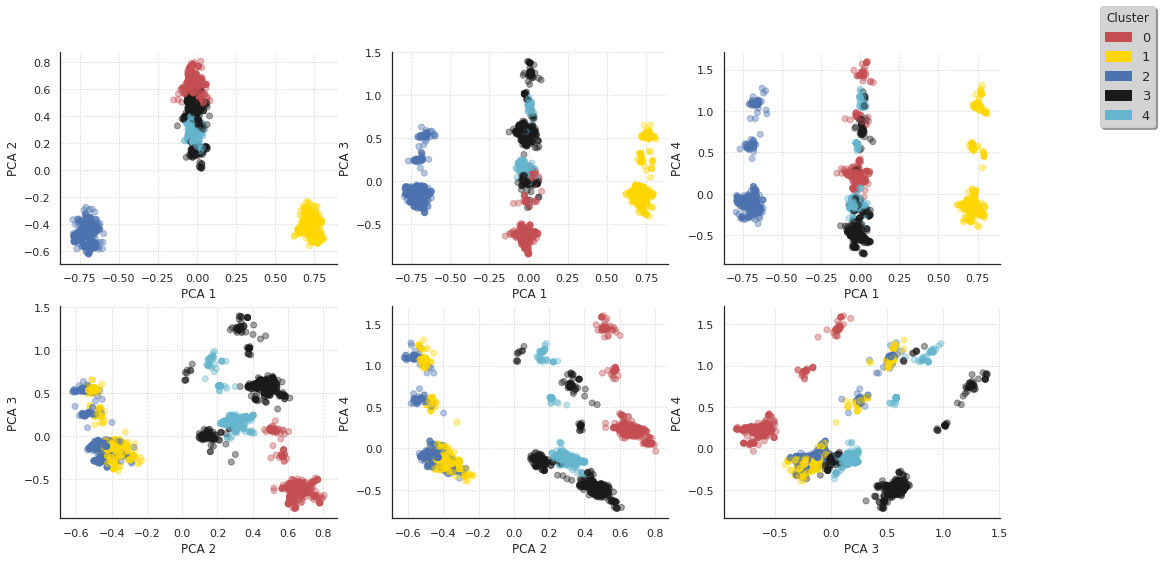

In [0]:
import matplotlib.patches as mpatches

sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

LABEL_COLOR_MAP = {0:'r', 1:'gold', 2:'b', 3:'k', 4:'c', 5:'g'}
label_color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]

fig = plt.figure(figsize = (15,8))
increment = 0
for ix in range(4):
    for iy in range(ix+1, 4):    
        increment += 1
        ax = fig.add_subplot(2,3,increment)
        ax.scatter(mat[ix], mat[iy], c= label_color, alpha=0.4) 
        plt.ylabel('PCA {}'.format(iy+1), fontsize = 12)
        plt.xlabel('PCA {}'.format(ix+1), fontsize = 12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        if increment == 9: break
    if increment == 9: break
        
#_______________________________________________
# I set the legend: abreviation -> airline name
comp_handler = []
for i in range(5):
    comp_handler.append(mpatches.Patch(color = LABEL_COLOR_MAP[i], label = i))

plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.97), 
           title='Cluster', facecolor = 'lightgrey',
           shadow = True, frameon = True, framealpha = 1,
           fontsize = 13, bbox_transform = plt.gcf().transFigure)

plt.show()

Hình trên thấy các cụm được phân bố đều không bị trùng nhiều nên về cơ bản là tốt.

4. Phân loại người dùng

Biến **categ_product** được thêm vào dữ liệu để định danh **index** của từng **cụm cluster** cho mỗi **product** khác nhau.

In [0]:
#4. Customer categories
corresp = dict()
for key, val in zip (liste_produits, clusters):
    corresp[key] = val 
#__________________________________________________________________________
df_cleaned['categ_product'] = df_cleaned.loc[:, 'Description'].map(corresp)

4.1.1 Gôm cụm sản phẩm

 **cate_N** với **N∈[0:4]** tượng trưng cho số tiền tiêu cho từng loại **cate_N**  

In [0]:
#4.1.1 Grouping products
for i in range(5):
    col = 'categ_{}'.format(i)        
    df_temp = df_cleaned[df_cleaned['categ_product'] == i]
    price_temp = df_temp['UnitPrice'] * (df_temp['Quantity'] - df_temp['QuantityCanceled'])
    price_temp = price_temp.apply(lambda x:x if x > 0 else 0)
    df_cleaned.loc[:, col] = price_temp
    df_cleaned[col].fillna(0, inplace = True)
#__________________________________________________________________________________________________
df_cleaned[['InvoiceNo', 'Description', 'categ_product', 'categ_0', 'categ_1', 'categ_2', 'categ_3','categ_4']][:5]

,InvoiceNo,Description,categ_product,categ_0,categ_1,categ_2,categ_3,categ_4
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,0,15.3,0.0,0.0,0.00,0.0
1,536365,WHITE METAL LANTERN,3,0.0,0.0,0.0,20.34,0.0
2,536365,CREAM CUPID HEARTS COAT HANGER,3,0.0,0.0,0.0,22.00,0.0
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,3,0.0,0.0,0.0,20.34,0.0
4,536365,RED WOOLLY HOTTIE WHITE HEART.,3,0.0,0.0,0.0,20.34,0.0


BasketPrice sẽ là table mới loại bỏ đi các cột không cần thiết cho việc giải thích sử liên quản của người dùng và các cụm sản phẩm.



In [0]:
#___________________________________________
# somme des achats / utilisateur & commande
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice':'Basket Price'})
#____________________________________________________________
# pourcentage du prix de la commande / categorie de produit
for i in range(5):
    col = 'categ_{}'.format(i) 
    temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)[col].sum()
    basket_price.loc[:, col] = temp 

df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df_cleaned.drop('InvoiceDate_int', axis = 1, inplace = True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])

basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID', ascending = True)[:5]

,CustomerID,InvoiceNo,Basket Price,categ_0,categ_1,categ_2,categ_3,categ_4,InvoiceDate
1,12347,537626,711.79,83.40,187.2,23.40,293.35,124.44,2010-12-07 14:57:00.000001024
2,12347,542237,475.39,53.10,130.5,84.34,207.45,0.00,2011-01-26 14:29:59.999999744
3,12347,549222,636.25,71.10,330.9,81.00,153.25,0.00,2011-04-07 10:42:59.999999232
4,12347,556201,382.52,78.06,74.4,41.40,168.76,19.90,2011-06-09 13:01:00.000000256
5,12347,562032,584.91,119.70,109.7,61.30,196.41,97.80,2011-08-02 08:48:00.000000000


Thời gian **nhỏ nhất** và **lớn nhất** trên cột **InvoiceDate**

4.1.2 Phân bổ thời gian

In [0]:
#4.1.2 Separation of data over time
print(basket_price['InvoiceDate'].min(), '->',  basket_price['InvoiceDate'].max())

2010-12-01 08:26:00 -> 2011-12-09 12:50:00


In [0]:
set_entrainement = basket_price[basket_price['InvoiceDate'] < pd.to_datetime('20111101', format='%Y%m%d', errors='ignore')]
set_test         = basket_price[basket_price['InvoiceDate'] >= pd.to_datetime('20111101', format='%Y%m%d', errors='ignore')]
basket_price = set_entrainement.copy(deep = True)

Để tiện cho việc quan sát thì các chỉ số như count, min, max, mean, sum được tính chung vào một hàng.

In [0]:
# 4.1.3 Consumer Order Combinations
transactions_per_user=basket_price.groupby(by=['CustomerID'])['Basket Price'].agg(['count','min','max','mean','sum'])

for i in range(5):
    col = 'categ_{}'.format(i)
    transactions_per_user.loc[:,col] = basket_price.groupby(by=['CustomerID'])[col].sum() / transactions_per_user['sum']*100

transactions_per_user.reset_index(drop = False, inplace = True)
basket_price.groupby(by=['CustomerID'])['categ_0'].sum()
transactions_per_user.sort_values('CustomerID', ascending = True)[:5]

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4
0,12347,6,382.52,1294.32,680.863333,4085.18,20.592973,25.359960,10.911147,35.847625,7.288296
1,12348,4,227.44,892.80,449.310000,1797.24,0.000000,41.953217,38.016069,20.030714,0.000000
2,12350,1,334.40,334.40,334.400000,334.40,27.900718,48.444976,11.692584,11.961722,0.000000
3,12352,6,144.35,840.30,345.663333,2073.98,3.370331,12.892120,0.491808,68.944734,14.301006
4,12353,1,89.00,89.00,89.000000,89.00,19.887640,13.033708,0.000000,44.719101,22.359551


Cột **FirstPurchase** nghĩa là số ngày bắt đầu từ lần đầu giao dịch, **LastPurchase** nghĩa là số ngày bắt đầu từ lần cuối giao dịch.

In [0]:
last_date = basket_price['InvoiceDate'].max().date()

first_registration = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].min())
last_purchase      = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].max())

test  = first_registration.applymap(lambda x:(last_date - x.date()).days)
test2 = last_purchase.applymap(lambda x:(last_date - x.date()).days)

transactions_per_user.loc[:, 'LastPurchase'] = test2.reset_index(drop = False)['InvoiceDate']
transactions_per_user.loc[:, 'FirstPurchase'] = test.reset_index(drop = False)['InvoiceDate']

transactions_per_user[:5]

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,LastPurchase,FirstPurchase
0,12347,6,382.52,1294.32,680.863333,4085.18,20.592973,25.359960,10.911147,35.847625,7.288296,0,328
1,12348,4,227.44,892.80,449.310000,1797.24,0.000000,41.953217,38.016069,20.030714,0.000000,36,319
2,12350,1,334.40,334.40,334.400000,334.40,27.900718,48.444976,11.692584,11.961722,0.000000,271,271
3,12352,6,144.35,840.30,345.663333,2073.98,3.370331,12.892120,0.491808,68.944734,14.301006,33,257
4,12353,1,89.00,89.00,89.000000,89.00,19.887640,13.033708,0.000000,44.719101,22.359551,165,165


Tỉ lê số lượng khách hàng chỉ có một lần giao dịch.

In [0]:
n1 = transactions_per_user[transactions_per_user['count'] == 1].shape[0]
n2 = transactions_per_user.shape[0]
print("Tỉ lê khách hàng chỉ mua một lần : {:<2}/{:<5} ({:<2.2f}%)".format(n1,n2,n1/n2*100))

Tỉ lê khách hàng chỉ mua một lần : 1536/3965  (38.74%)


4.2 Bắt đầu phân loại người dùng

4.2.1 Mã hóa dữ liệu

**transactions_per_user** có nhiều dữ liệu mà lúc này không cần nữa nên sẽ lọc ra chỉ những cột cần thiết cho mô hình.

In [0]:
list_cols = ['count','min','max','mean','categ_0','categ_1','categ_2','categ_3','categ_4']
#_____________________________________________________________
selected_customers = transactions_per_user.copy(deep = True)
matrix = selected_customers[list_cols].values

Chuẩn hóa dữ liệu

In [0]:
scaler = StandardScaler()
scaler.fit(matrix)
print('Giá trị trung bình của các biến : \n' + 90*'-' + '\n' , scaler.mean_)
scaled_matrix = scaler.transform(matrix)

Giá trị trung bình của các biến : 
------------------------------------------------------------------------------------------
 [  3.7778058  255.04367011 570.63018739 378.23155283  21.22745199
  25.19541167  14.10994027  24.15547662  15.31983479]


In [0]:
matrix.shape

(3965, 9)

Tiếp theo sẽ dùng PCA để phân cụm người dùng

In [0]:
pca = PCA()
pca.fit(scaled_matrix)
pca_samples = pca.transform(scaled_matrix)

sô lượng cột hiện tại của matrix đang là

In [0]:
matrix.shape[1]

9

Biểu đồ thế hiện sự phân bổ dựa trên component ở đây là các biến.

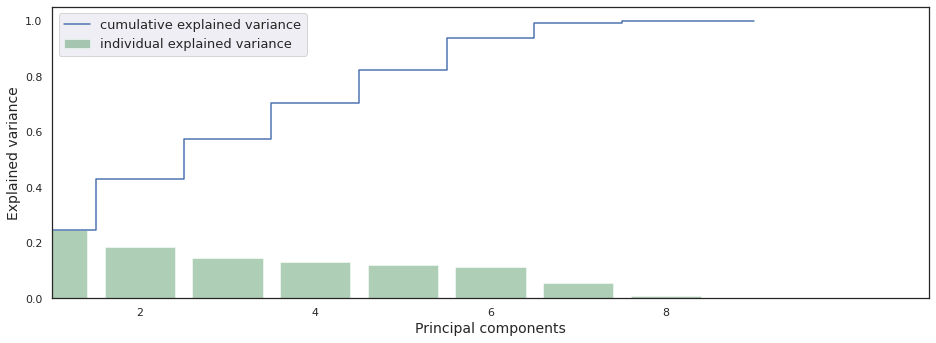

In [0]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='cumulative explained variance')
sns.barplot(np.arange(1,matrix.shape[1]+1), pca.explained_variance_ratio_, alpha=0.5, color = 'g',
            label='individual explained variance')
plt.xlim(0, 10)

ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='best', fontsize = 13);

4.2.2 Phân loại khách hàng.

Dùng KMeans từ thư viện sklearn để chia cụm cluster, số lượng cluster được chọn là 11 ( do đã thử nhiều lần và chọn được dưa trên silhouette score). 

In [0]:
n_clusters = 11
kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=100)
kmeans.fit(scaled_matrix)
clusters_clients = kmeans.predict(scaled_matrix)
silhouette_avg = silhouette_score(scaled_matrix, clusters_clients)
print('silhouette score: {:<.3f}'.format(silhouette_avg))

silhouette score: 0.212


Tổng là 11 cụm người dùng sau khi chạy xong Kmeans, bắt đầu từ 0 đến 10.

In [0]:
pd.DataFrame(pd.Series(clusters_clients).value_counts(), columns = ['Số lượng người dùng ']).T

,2,5,0,10,4,8,9,1,3,7,6
Số lượng người dùng,1568,516,482,358,334,296,210,172,13,8,8


Tìm hiểu về  từng cụm cluster thông qua PCA.

In [0]:
pca = PCA(n_components=6)
matrix_3D = pca.fit_transform(scaled_matrix)
mat = pd.DataFrame(matrix_3D)
mat['cluster'] = pd.Series(clusters_clients)

Thống kê phân bổ của từng cụm cluster qua mô phỏng

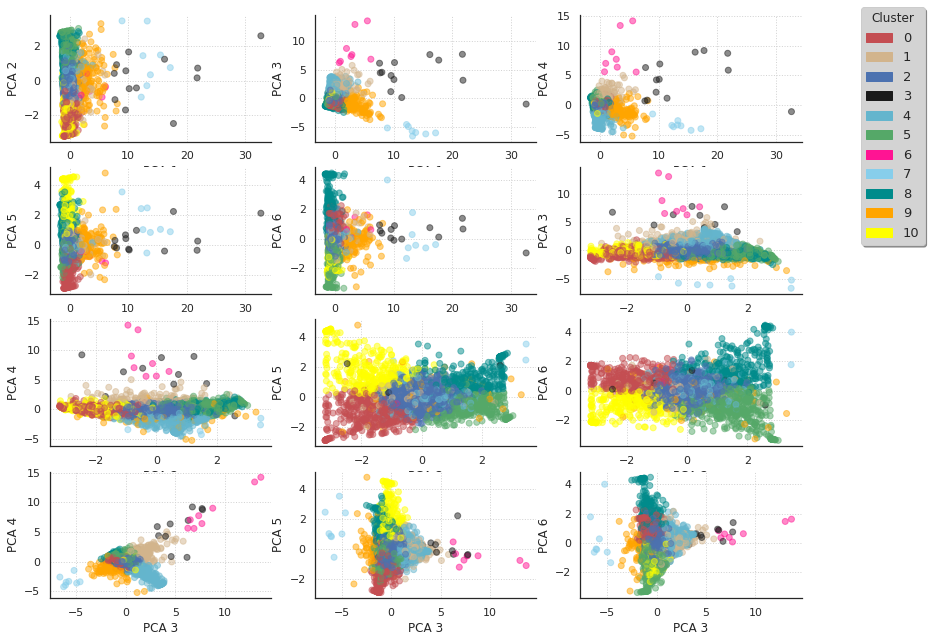

In [0]:
import matplotlib.patches as mpatches

sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

# Color map with label
LABEL_COLOR_MAP = {0:'r', 1:'tan', 2:'b', 3:'k', 4:'c', 5:'g', 6:'deeppink', 7:'skyblue', 8:'darkcyan', 9:'orange',
                   10:'yellow', 11:'tomato', 12:'seagreen'}
label_color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]

fig = plt.figure(figsize = (12,10))
increment = 0
for ix in range(6):
    for iy in range(ix+1, 6):   
        increment += 1
        ax = fig.add_subplot(4,3,increment)
        ax.scatter(mat[ix], mat[iy], c= label_color, alpha=0.5) 
        plt.ylabel('PCA {}'.format(iy+1), fontsize = 12)
        plt.xlabel('PCA {}'.format(ix+1), fontsize = 12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        if increment == 12: break
    if increment == 12: break
        
#_______________________________________________
# I set the legend: abreviation -> airline name
comp_handler = []
for i in range(n_clusters):
    comp_handler.append(mpatches.Patch(color = LABEL_COLOR_MAP[i], label = i))

plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.9), 
           title='Cluster', facecolor = 'lightgrey',
           shadow = True, frameon = True, framealpha = 1,
           fontsize = 13, bbox_transform = plt.gcf().transFigure)

plt.tight_layout()

Từ môt phỏng của hình bên trên ta thấy được PCA đầu tiên ( bắt đầu từ ô 1 đến ô 5) thế hiện được rõ sự phân bổ của các cụm, PCA 2 ( bắt đầu từ ô 6 đến còn lai) không cho thấy sự phân cụm tốt như vậy.

Một cách mô phỏng khác để đo đạc chất lượng của kết quả phân cụm là thông qua chỉ số silhouette, documentaion của cách mô phỏng này https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

Điểm silhouette của mỗi điểm càng to nghĩa là điểm đó càng thuộc về cụm cluster đó và ngược lại.

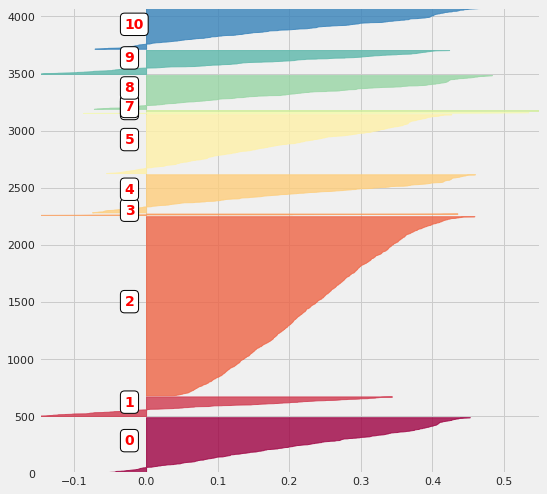

In [0]:
sample_silhouette_values = silhouette_samples(scaled_matrix, clusters_clients)
#____________________________________
# define individual silouhette scores
sample_silhouette_values = silhouette_samples(scaled_matrix, clusters_clients)
#__________________
# and do the graph
graph_component_silhouette(n_clusters, [-0.15, 0.55], len(scaled_matrix), sample_silhouette_values, clusters_clients)

In [0]:
selected_customers.loc[:, 'cluster'] = clusters_clients

Sau quá trình mô phỏng thì ta xác định sự phân bổ của các cụm là đều, điều đó cũng đồng nghĩa với viêc thói quen của người dùng đã được phân loại rõ ràng.

In [0]:
merged_df = pd.DataFrame()
for i in range(n_clusters):
    test = pd.DataFrame(selected_customers[selected_customers['cluster'] == i].mean())
    test = test.T.set_index('cluster', drop = True)
    test['size'] = selected_customers[selected_customers['cluster'] == i].shape[0]
    merged_df = pd.concat([merged_df, test])
#_____________________________________________________
merged_df.drop('CustomerID', axis = 1, inplace = True)
print('number of customers:', merged_df['size'].sum())

merged_df = merged_df.sort_values('sum')

number of customers: 3965


Dữ liệu tổng quát của từng cụm người dùng từ [0..10]

Sắp xếp lại merged_df theo tiêu chí là các categ_{}

In [0]:
liste_index = []
for i in range(5):
    column = 'categ_{}'.format(i)
    liste_index.append(merged_df[merged_df[column] > 45].index.values[0])
#___________________________________
liste_index_reordered = liste_index
liste_index_reordered += [ s for s in merged_df.index if s not in liste_index]
#___________________________________________________________
merged_df = merged_df.reindex(index = liste_index_reordered)
merged_df = merged_df.reset_index(drop = False)
display(merged_df[['cluster', 'count', 'min', 'max', 'mean', 'sum', 'categ_0',
                   'categ_1', 'categ_2', 'categ_3', 'categ_4', 'size']])

,cluster,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,size
0,4.0,2.709581,202.606018,381.152575,287.159693,847.266617,59.700574,15.508332,7.799702,10.353890,6.637502,334
1,5.0,2.527132,212.379264,343.892579,274.389653,712.263277,13.660581,56.181322,12.589288,11.788623,5.784118,516
2,8.0,2.270270,190.635169,318.220338,246.614535,592.028716,11.295657,20.264705,54.191875,8.604830,5.642933,296
3,0.0,2.253112,210.720041,349.561535,271.236277,691.780622,11.502355,11.360970,5.592389,58.802267,12.754465,482
4,10.0,2.578212,194.283299,315.728966,248.280393,662.659304,11.588795,11.823634,5.010233,19.222585,52.370515,358
5,2.0,3.374362,217.351876,486.283451,339.133910,1160.742456,22.215735,25.353468,13.611857,24.213348,14.615629,1568
6,9.0,1.961905,1018.689619,1475.451767,1226.307407,2601.919671,21.470106,26.482752,11.710073,27.098493,13.238898,210
7,7.0,1.375000,4190.341250,4374.533750,4282.437500,5982.383750,11.509896,19.140409,28.173846,27.202515,13.973333,8
8,1.0,18.953488,77.760581,1397.396919,508.527109,9394.813314,23.814726,23.833618,12.213842,23.889174,16.263361,172
9,6.0,98.000000,20.862500,2643.812500,472.077608,43352.805000,24.669429,25.303388,11.674105,22.394356,15.979877,8


Bước mô phỏng dữ liệu cuối cùng sẽ dùng Radar chart để thấy thói quen tiêu dùng của đối tượng người dùng trong từng cụm 

Radar chart documentation : https://plotly.com/python/radar-chart/

In [0]:
def _scale_data(data, ranges):
    (x1, x2) = ranges[0]
    d = data[0]
    return [(d - y1) / (y2 - y1) * (x2 - x1) + x1 for d, (y1, y2) in zip(data, ranges)]

class RadarChart():
    def __init__(self, fig, location, sizes, variables, ranges, n_ordinate_levels = 6):

        angles = np.arange(0, 360, 360./len(variables))

        ix, iy = location[:] ; size_x, size_y = sizes[:]
        
        axes = [fig.add_axes([ix, iy, size_x, size_y], polar = True, 
        label = "axes{}".format(i)) for i in range(len(variables))]

        _, text = axes[0].set_thetagrids(angles, labels = variables)
        
        for txt, angle in zip(text, angles):
            if angle > -1 and angle < 181:
                txt.set_rotation(angle - 90)
            else:
                txt.set_rotation(angle - 270)
        
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.xaxis.set_visible(False)
            ax.grid("off")
        
        for i, ax in enumerate(axes):
            grid = np.linspace(*ranges[i],num = n_ordinate_levels)
            grid_label = [""]+["{:.0f}".format(x) for x in grid[1:-1]]
            ax.set_rgrids(grid, labels = grid_label, angle = angles[i])
            ax.set_ylim(*ranges[i])
        
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]
                
    def plot(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def legend(self, *args, **kw):
        self.ax.legend(*args, **kw)
        
    def title(self, title, *args, **kw):
        self.ax.text(0.9, 1, title, transform = self.ax.transAxes, *args, **kw)

Radar chart cho một cái nhìn tổng quát về sự khác nhau của từng cụm

Tổng là 11 cụm người dùng đã được phân ra

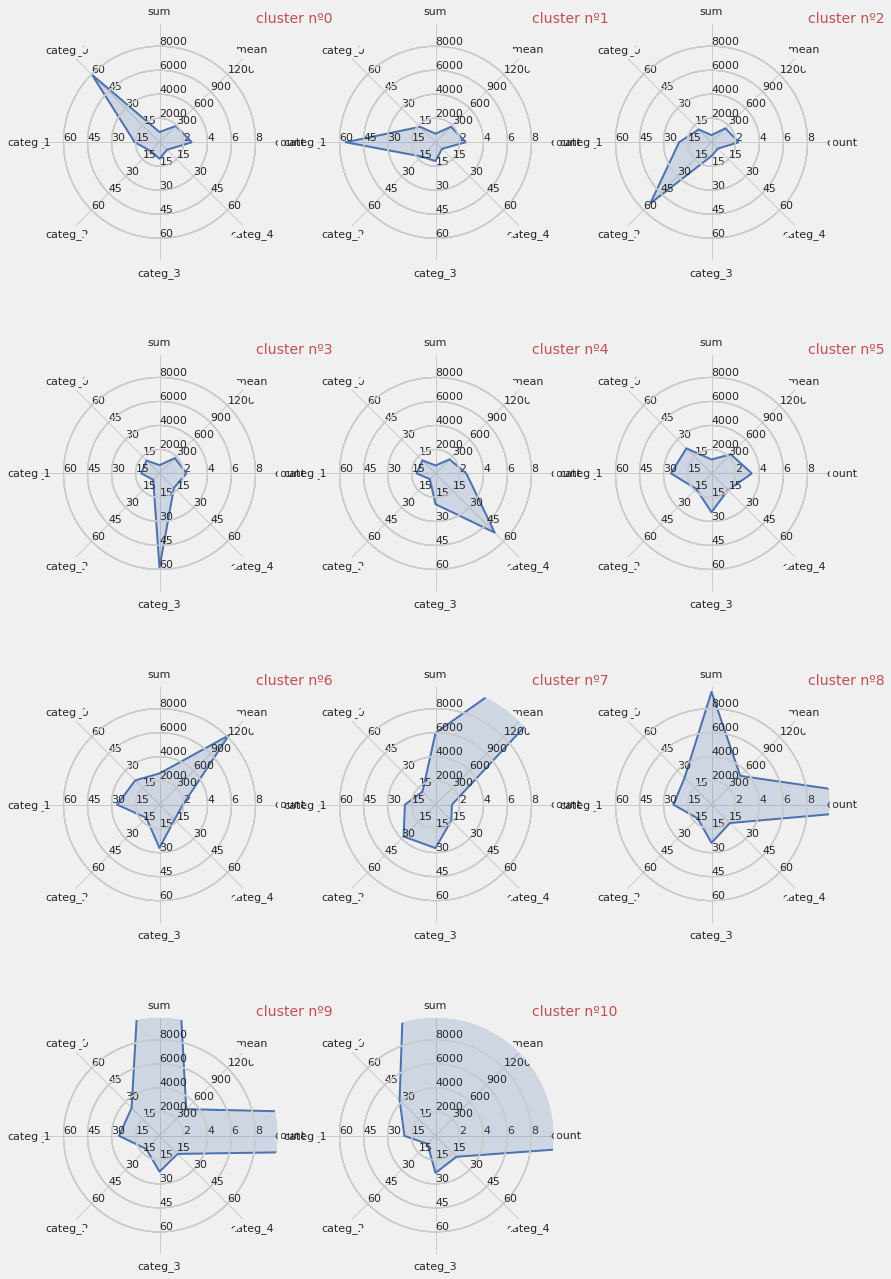

In [0]:
fig = plt.figure(figsize=(10,12))

attributes = ['count', 'mean', 'sum', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4']
ranges = [[0.01, 10], [0.01, 1500], [0.01, 10000], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75]]
index  = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

n_groups = n_clusters ; i_cols = 3
i_rows = n_groups//i_cols
size_x, size_y = (1/i_cols), (1/i_rows)

for ind in range(n_clusters):
    ix = ind%3 ; iy = i_rows - ind//3
    pos_x = ix*(size_x + 0.05) ; pos_y = iy*(size_y + 0.05)            
    location = [pos_x, pos_y]  ; sizes = [size_x, size_y] 
    #______________________________________________________
    data = np.array(merged_df.loc[index[ind], attributes])    
    radar = RadarChart(fig, location, sizes, attributes, ranges)
    radar.plot(data, color = 'b', linewidth=2.0)
    radar.fill(data, alpha = 0.2, color = 'b')
    radar.title(title = 'cluster nº{}'.format(index[ind]), color = 'r')
    ind += 1 

Từ hình bên trên, dễ dàng thấy được là 5 radar chart đầu tiên là những cụm người dùng thiên về một cụm sản phẩm nhất định còn các radar chart tiếp theo thiên về lượng tiêu dùng trung bình, tổng chi tiêu, và tổng số lần giao dịch.

**5. Thử phân loại người dùng trên nhiều thuật toán khác nhau.**

Tạo ra một class giúp dễ dàng quản lý và gọi các hàm từ các thuật toán **classifier** từ **sklearn**

In [0]:
class Class_Fit(object):
    def __init__(self, clf, params=None):
        if params:            
            self.clf = clf(**params)
        else:
            self.clf = clf()

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def grid_search(self, parameters, Kfold):
        self.grid = GridSearchCV(estimator = self.clf, param_grid = parameters, cv = Kfold)
        
    def grid_fit(self, X, Y):
        self.grid.fit(X, Y)
        
    def grid_predict(self, X, Y):
        self.predictions = self.grid.predict(X)
        print("Độ chính xác : {:.2f} % ".format(100*metrics.accuracy_score(Y, self.predictions)))

Chỉ dùng các cột có liên quan đến thông tin của mỗi giao dịch, bỏ đi các cột về số lần sử dụng trang web.

Mục tiêu là phân loại người dùng nên **Y** sẽ là cột **cluster**

In [0]:
columns = ['mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4' ]
X = selected_customers[columns]
Y = selected_customers['cluster']

Cuối cùng, chia dữ liệu ban đầu ra làm hai phần 80% cho việc train và 20% cho việc test.

In [0]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, train_size = 0.8)

Train sử dụng thuật toán **Decision Tree**

In [0]:
tr = Class_Fit(clf = tree.DecisionTreeClassifier)
tr.grid_search(parameters = [{'criterion' : ['entropy', 'gini'], 'max_features' :['sqrt', 'log2']}], Kfold = 5)
tr.grid_fit(X = X_train, Y = Y_train)
tr.grid_predict(X_test, Y_test)

Độ chính xác : 81.59 % 


Train sử dụng thuật toán **Random Forest**.

In [0]:
rf = Class_Fit(clf = ensemble.RandomForestClassifier)
param_grid = {'criterion' : ['entropy', 'gini'], 'n_estimators' : [20, 40, 60, 80, 100],
               'max_features' :['sqrt', 'log2']}
rf.grid_search(parameters = param_grid, Kfold = 5)
rf.grid_fit(X = X_train, Y = Y_train)
rf.grid_predict(X_test, Y_test)

Độ chính xác : 90.29 % 


Train sử dụng thuật toán **Adaboost**.

In [0]:
ada = Class_Fit(clf = AdaBoostClassifier)
param_grid = {'n_estimators' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
ada.grid_search(parameters = param_grid, Kfold = 5)
ada.grid_fit(X = X_train, Y = Y_train)
ada.grid_predict(X_test, Y_test)

Độ chính xác : 51.20 % 


Train sử dụng thuật toán **K-Nearest Neighbors**.

In [0]:
knn = Class_Fit(clf = neighbors.KNeighborsClassifier)
knn.grid_search(parameters = [{'n_neighbors': np.arange(1,50,1)}], Kfold = 5)
knn.grid_fit(X = X_train, Y = Y_train)
knn.grid_predict(X_test, Y_test)

Độ chính xác : 79.57 % 
